# Import Necessary Libraries

In [1]:
import gym
import torch
import numpy as np
from ipynb.fs.full.BreakoutPPO import Agent
from utils import plot_learning_curve

In [2]:
# Preprocess image(Code from class)
def prepro(image):
    image = image[35:195]  # crop
    image = image[::2, ::2, 0]  # downsample by factor of 2
    image[image == 144] = 0  # erase background (background type 1)
    image[image == 109] = 0  # erase background (background type 2)
    image[image != 0] = 1  # everything else (paddles, ball) just set to 1
    return np.reshape(image, (1, 80, 80))


# Set Up Pong Environment

If it works on Pong environment, then it will likely work on the Breakout Environment as well (with a few tweaks)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/Users/stanleyaraki/miniconda3/lib/python3.9/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/stanleyaraki/miniconda3/lib/python3.9/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/stanleyaraki/Desktop/Data_Analysis_Portfolio/Proximal-Policy-Optimization/BreakoutPPO.ipynb:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/torch/csrc/utils/tensor_new.cpp:210.)
  "    def forward(self, state):\n",


... loading models ...
... saving models ...
episode 0 score -21.0 avg score -21.0 time_steps 853 learning_steps 42
episode 1 score -21.0 avg score -21.0 time_steps 1758 learning_steps 87
episode 2 score -21.0 avg score -21.0 time_steps 2570 learning_steps 128
episode 3 score -21.0 avg score -21.0 time_steps 3391 learning_steps 169
episode 4 score -21.0 avg score -21.0 time_steps 4240 learning_steps 212
episode 5 score -21.0 avg score -21.0 time_steps 5005 learning_steps 250
episode 6 score -21.0 avg score -21.0 time_steps 5798 learning_steps 289
... saving models ...
episode 7 score -20.0 avg score -20.9 time_steps 6753 learning_steps 337
episode 8 score -21.0 avg score -20.9 time_steps 7658 learning_steps 382
episode 9 score -21.0 avg score -20.9 time_steps 8469 learning_steps 423
episode 10 score -21.0 avg score -20.9 time_steps 9290 learning_steps 464
episode 11 score -21.0 avg score -20.9 time_steps 10083 learning_steps 504
episode 12 score -21.0 avg score -20.9 time_steps 10866 l

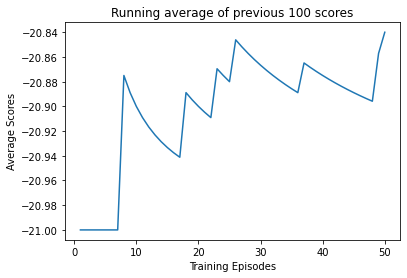

In [3]:
if __name__ == '__main__':
    env = gym.make('ALE/Pong-v5')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003

    raw_image = env.reset()
    preprocessed_image = prepro(raw_image) #(1, 80, 80)

    flattened = preprocessed_image.flatten()
    agent = Agent(num_actions = env.action_space.n, batch_size = 5, alpha = 0.0003, num_epochs = 4, input_dims = flattened.shape)
    agent.load_models()
    n_games = 50

    figure_file = 'plots/Pong.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games): # 103 min 8.8 sec for 300 iterations
        observation = env.reset()
        done = False
        score = 0
        while not done:
            observation = prepro(observation) # need to preprocess each time
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0: # if true, it's time to perform learning function
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score: # if best score found
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file, "Training Episodes", "Average Scores")

# Load previous Checkpoint

In [ ]:
agent.load_models()